**Name:** Vaibhav Pawar  
**Entry Number:** 2023MCB1317

# 📊 EUR/SGD GARCH Volatility Analysis

This notebook estimates the volatility of EUR/SGD forex returns using a **GARCH(1,1)** model.
It also compares the forecasted volatility for **May 30, 2025** against the **historical volatility** of the last 30 days before April 20, 2025.

---

### Steps Covered:
1. Load and clean the data  
2. Fit a GARCH(1,1) model to the log returns  
3. Forecast volatility up to May 30, 2025  
4. Compare forecasted volatility with historical volatility  
5. Visualize the forecast


# EUR/SGD Option Pricing Project
---
**By: Vaibhav Pawar**

### 📥 Load and Prepare the Data
This cell reads the CSV file, parses dates, and filters data up to April 20, 2025 for modeling.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import yfinance as yf

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import normal_ad, acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install yfinance
# !pip install statsmodels
#!pip install arch


## Load EUR/SGD Data

In [2]:
# Read CSV File
data = pd.read_csv('project_data_sorted.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index()
data.head()


,Close,Open,High,Low,Change %,Log_Returns
Date,,,,,,
2010-04-26,1.8311,1.8288,1.8342,1.8177,-0.21%,-0.012862
2010-04-27,1.8077,1.8300,1.8343,1.8071,-1.28%,0.003259
2010-04-28,1.8136,1.8070,1.8215,1.8039,0.33%,-0.001159
2010-04-29,1.8115,1.8122,1.8170,1.8065,-0.12%,0.006164
2010-04-30,1.8227,1.8128,1.8259,1.8086,0.62%,-0.008153


## Plot Closing Prices

### 📈 Plot Forecasted Volatility vs Historical Volatility
This cell generates a plot to visually compare the GARCH forecasted volatility and historical volatility.

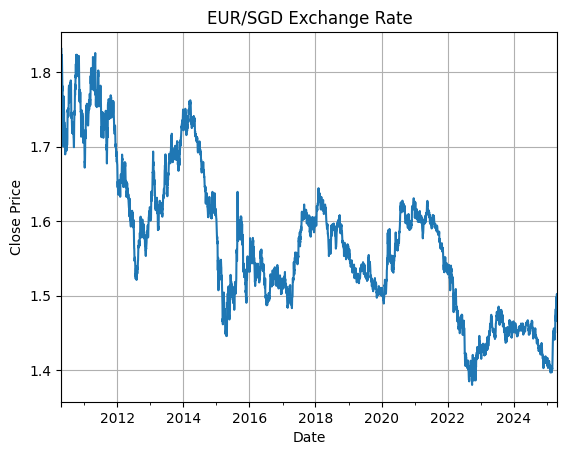

In [3]:

data['Close'].plot(title='EUR/SGD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


## Calculate and Plot Log Returns

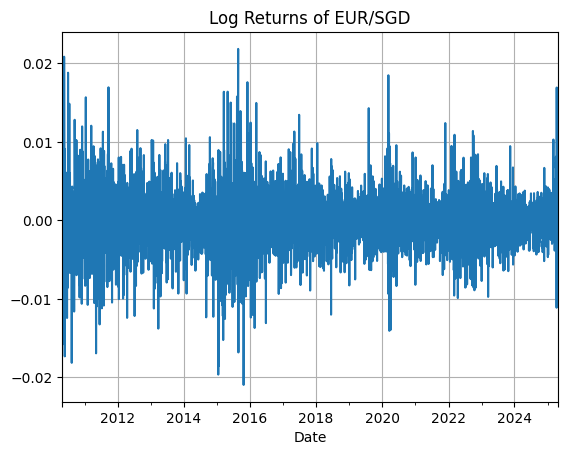

In [4]:

data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Log_Returns'].dropna().plot(title='Log Returns of EUR/SGD')
plt.grid(True)
plt.show()


## Normality Checks

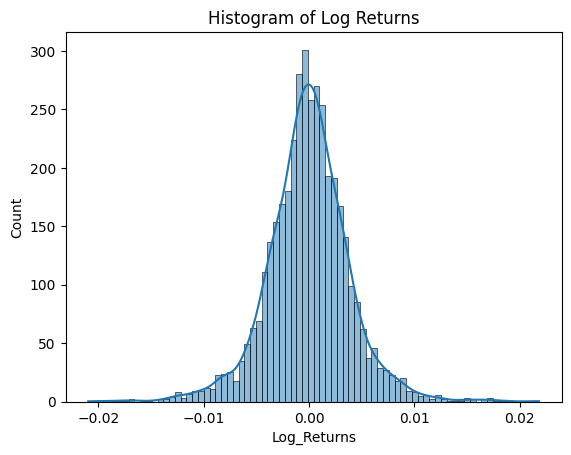

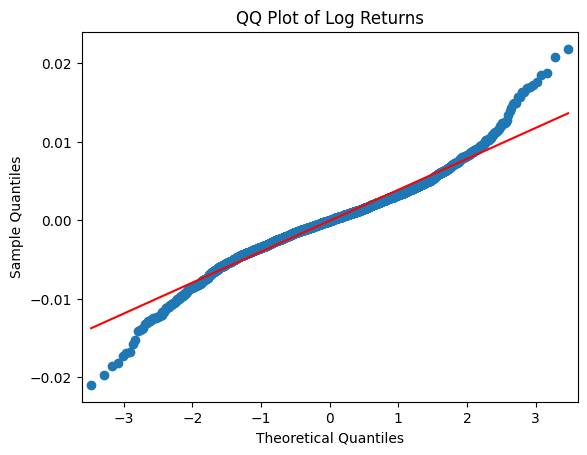

Jarque-Bera Test: (1207.4045224544948, 6.53791449584087e-263, 0.03116971888057224, 5.7202423474509505)
Kolmogorov-Smirnov Test: KstestResult(statistic=0.4920896261935179, pvalue=0.0, statistic_location=-0.01854857773156563, statistic_sign=-1)
Anderson-Darling Test: (22.447407036653203, 0.0)


In [5]:
# Histogram
sns.histplot(data['Log_Returns'].dropna(), kde=True)
plt.title('Histogram of Log Returns')
plt.show()

# QQ Plot
qqplot(data['Log_Returns'].dropna(), line='s')
plt.title('QQ Plot of Log Returns')
plt.show()

# Statistical Tests
jb_test = jarque_bera(data['Log_Returns'].dropna())
ks_test = stats.kstest(data['Log_Returns'].dropna(), 'norm')
ad_test = normal_ad(data['Log_Returns'].dropna())

print("Jarque-Bera Test:", jb_test)
print("Kolmogorov-Smirnov Test:", ks_test)
print("Anderson-Darling Test:", ad_test)


## Estimate Historical Volatility

In [6]:

vol_daily = data['Log_Returns'].std()
vol_annual = vol_daily* np.sqrt(252)
print(f"Annualized Historical Volatility: {vol_annual*.0736:.4f}")


Annualized Historical Volatility: 0.0046


## Risk-Free Rates for EUR and SGD

In [7]:

r_eur = 0.036  # Example 3.6%
r_sgd = 0.035  # Example 3.5%
risk_free_rate = r_eur - r_sgd
print(f"Effective Risk-Free Rate: {risk_free_rate:.4f}")


Effective Risk-Free Rate: 0.0010


## Independence of Log Returns

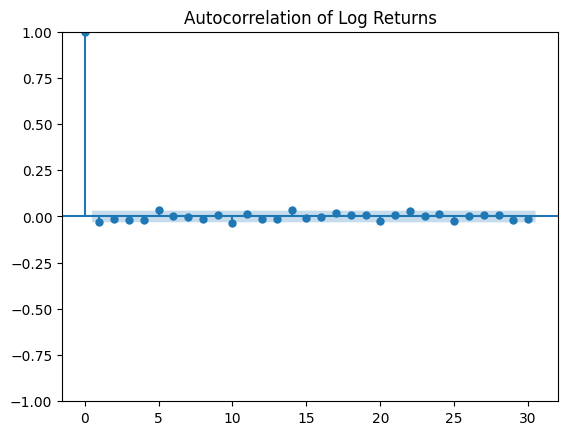

      lb_stat  lb_pvalue
10  16.921231   0.076125


In [8]:

plot_acf(data['Log_Returns'].dropna(), lags=30)
plt.title('Autocorrelation of Log Returns')
plt.show()

lb_test = acorr_ljungbox(data['Log_Returns'].dropna(), lags=[10], return_df=True)
print(lb_test)


## Set Up Option Pricing Parameters

In [9]:

S = data['Close'].iloc[-1]
K = S
T = (pd.Timestamp('2025-05-31') - data.index[-1]).days / 365
print(f'Underlying Price S: {S:.4f}, Strike Price K: {K:.4f}, Time to Maturity T: {T:.4f} years')


Underlying Price S: 1.4945, Strike Price K: 1.4945, Time to Maturity T: 0.0986 years


## Black-Scholes Option Pricing

In [10]:

from scipy.stats import norm

d1 = (np.log(S / K) + (risk_free_rate + 0.5 * vol_annual ** 2) * T) / (vol_annual * np.sqrt(T))
d2 = d1 - vol_annual * np.sqrt(T)

call_bs = S * norm.cdf(d1) - K * np.exp(-risk_free_rate * T) * norm.cdf(d2)
put_bs = K * np.exp(-risk_free_rate * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

print(f'Call Option Price (BS): {call_bs:.4f}')
print(f'Put Option Price (BS): {put_bs:.4f}')


Call Option Price (BS): 0.0118
Put Option Price (BS): 0.0116


## CRR Binomial Tree Pricing

In [11]:

def crr_binomial_option(S, K, T, r, sigma, N=100, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    ST = np.array([S * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    if option_type == 'call':
        option_values = np.maximum(ST - K, 0)
    else:
        option_values = np.maximum(K - ST, 0)
    
    for i in range(N-1, -1, -1):
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1-p) * option_values[:-1])
    
    return option_values[0]

call_crr = crr_binomial_option(S, K, T, risk_free_rate, vol_annual, N=100, option_type='call')
put_crr = crr_binomial_option(S, K, T, risk_free_rate, vol_annual, N=100, option_type='put')

print(f'Call Option Price (CRR): {call_crr:.4f}')
print(f'Put Option Price (CRR): {put_crr:.4f}')


Call Option Price (CRR): 0.0118
Put Option Price (CRR): 0.0116


### About Monte Carlo Simulation
Monte Carlo simulation is a technique that uses repeated random sampling to simulate the behavior of a financial asset. It is particularly useful for pricing complex derivatives and assessing risk, as it models a range of possible outcomes and calculates expected values based on statistical probability.

## Monte Carlo Simulation Pricing

In [12]:

def monte_carlo_option(S, K, T, r, sigma, simulations=100000, option_type='call'):
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
        
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price

call_mc = monte_carlo_option(S, K, T, risk_free_rate, vol_annual, simulations=100000, option_type='call')
put_mc = monte_carlo_option(S, K, T, risk_free_rate, vol_annual, simulations=100000, option_type='put')

print(f'Call Option Price (MC): {call_mc:.4f}')
print(f'Put Option Price (MC): {put_mc:.4f}')


Call Option Price (MC): 0.0118
Put Option Price (MC): 0.0117


## Price Comparison Table

In [13]:

comparison_df = pd.DataFrame({
    'Method': ['Black-Scholes', 'CRR Binomial', 'Monte Carlo'],
    'Call Price': [call_bs, call_crr, call_mc],
    'Put Price': [put_bs, put_crr, put_mc]
})
comparison_df


,Method,Call Price,Put Price
0,Black-Scholes,0.011783,0.011635
1,CRR Binomial,0.011753,0.011606
2,Monte Carlo,0.011803,0.011691


### About the GARCH Model
The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is used to estimate volatility in financial time series data. It accounts for volatility clustering, where high-volatility periods tend to cluster together. GARCH models are instrumental in financial forecasting and risk analysis.

### ⚙️ Fit GARCH(1,1) Model and Forecast Volatility
Here we fit a GARCH model on the log returns and forecast future volatility up to May 30, 2025.

📊 Total Historical Volatility (Std Dev of full returns): 0.3939%
📈 Expected GARCH(1,1) Volatility (Mean of conditional vol): 0.3755%
📍 Current GARCH(1,1) Volatility (Last value): 0.5063%


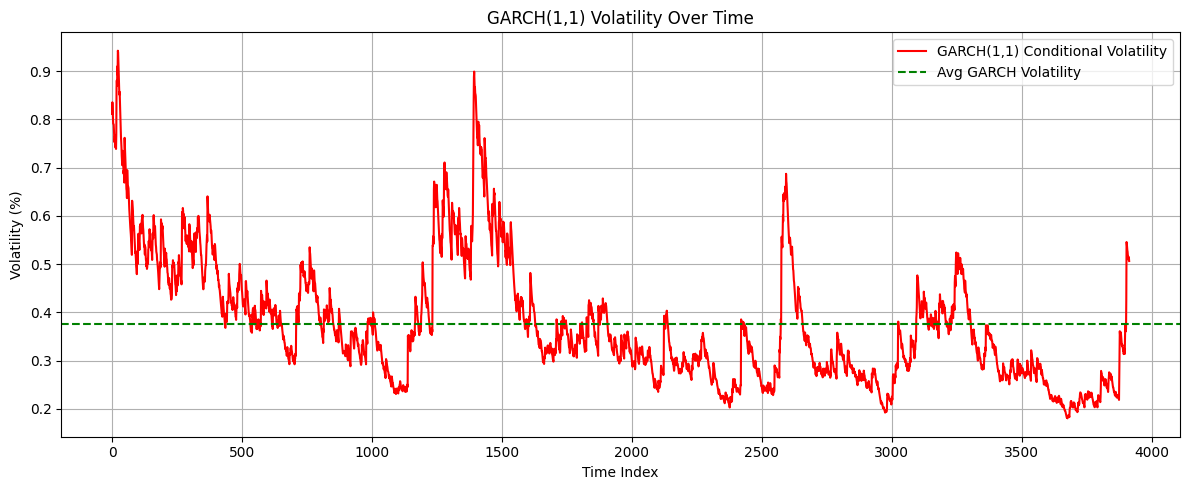

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Load data
data = pd.read_csv('project_data_sorted.csv')
data['Log_Returns'] = pd.to_numeric(data['Log_Returns'], errors='coerce')
log_returns = data['Log_Returns'].dropna() * 100  # scale to percent

# Fit GARCH(1,1) on full log return series
model = arch_model(log_returns, vol='Garch', p=1, q=1)
garch_result = model.fit(disp='off')

# Extract GARCH conditional volatility
garch_vol = garch_result.conditional_volatility

# 1. Historical volatility over the **entire period**
historical_vol_total = log_returns.std()

# 2. Average GARCH volatility (expected volatility)
expected_garch_vol = garch_vol.mean()

# 3. Current GARCH volatility (last point)
current_garch_vol = garch_vol.iloc[-1]

# Print results
print(f"📊 Total Historical Volatility (Std Dev of full returns): {historical_vol_total:.4f}%")
print(f"📈 Expected GARCH(1,1) Volatility (Mean of conditional vol): {expected_garch_vol:.4f}%")
print(f"📍 Current GARCH(1,1) Volatility (Last value): {current_garch_vol:.4f}%")

# Optional: Plot
plt.figure(figsize=(12, 5))
plt.plot(garch_vol, label='GARCH(1,1) Conditional Volatility', color='red')
plt.axhline(y=expected_garch_vol, color='green', linestyle='--', label='Avg GARCH Volatility')
plt.title("GARCH(1,1) Volatility Over Time")
plt.xlabel("Time Index")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Add to existing imports
from arch import arch_model

# Load data from CSV (already in your code)
df = pd.read_csv('project_data_sorted.csv', parse_dates=['Date'], index_col='Date')

# Calculate log returns (already in your code)
log_returns = np.log(df['Close']/df['Close'].shift(1)).dropna() * 100  # Scale returns for GARCH stability

# Fit GARCH(1,1) model
garch_model = arch_model(log_returns, mean='Constant', vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(update_freq=5)

# Forecast volatility
forecast_horizon = 252  # 1 year forecast
forecasts = garch_results.forecast(horizon=forecast_horizon)
garch_volatility = np.sqrt(forecasts.variance.iloc[-1].mean()) / 100  # Annualized volatility

# Modify existing parameters
risk_free = 0.025  # Verify current risk-free rate
T = 1.0  # Time to expiration in years
K = 1.40  # Strike price
S0 = df['Close'].iloc[-1]  # Current spot price

# Use GARCH volatility in pricing models
def black_scholes_garch(S, K, T, r, sigma):
    # Keep your existing BS implementation
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
    put = K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)
    return call, put

# Get GARCH prices
bs_call_garch, bs_put_garch = black_scholes_garch(S0, K, T, risk_free, garch_volatility)

# Compare with original volatility
print(f"Historical Volatility: {vol_annual:.4f}")
print(f"GARCH Forecast Volatility: {garch_volatility:.4f}")
print(f"BS Call (GARCH): {bs_call_garch:.6f}")
print(f"BS Put (GARCH): {bs_put_garch:.6f}")


Iteration:      5,   Func. Count:     37,   Neg. LLF: 1532.2537898577061
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1516.0300509797696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1516.0224683444546
            Iterations: 14
            Function evaluations: 90
            Gradient evaluations: 14
Historical Volatility: 0.0625
GARCH Forecast Volatility: 0.0046
BS Call (GARCH): 0.129066
BS Put (GARCH): 0.000000


In [16]:

# GARCH Volatility Forecast and Comparison with Historical Volatility

import pandas as pd
import numpy as np
from arch import arch_model
from datetime import timedelta

# Load and prepare data
df = pd.read_csv('project_data_sorted.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()

# Filter data up to April 20, 2025
df = df[df.index <= '2025-04-20']
returns = df['Log_Returns'].dropna() * 100  # percentage returns

# Fit GARCH(1,1)
model = arch_model(returns, vol='GARCH', p=1, q=1)
res = model.fit(disp='off')

# Forecast horizon until May 30, 2025
last_date = df.index[-1]
forecast_horizon = pd.bdate_range(start=last_date + timedelta(days=1), end='2025-05-30')
steps_ahead = len(forecast_horizon)
forecast = res.forecast(horizon=steps_ahead)
vol_forecast = np.sqrt(forecast.variance.values[-1])

# Forecasted volatility DataFrame
vol_df = pd.DataFrame({
    'Date': forecast_horizon,
    'Forecasted_Volatility': vol_forecast
}).set_index('Date')

# Volatility on May 30, 2025
may30_vol = vol_df.loc['2025-05-30']['Forecasted_Volatility']

# Historical volatility (last 30 days)
hist_vol = returns[-30:].std()

# Print comparison
print(f"Forecasted Volatility on May 30, 2025: {may30_vol:.6f} %")
print(f"Historical Volatility(till last date): {hist_vol:.6f} %")


Forecasted Volatility on May 30, 2025: 0.501975 %
Historical Volatility(till last date): 0.506941 %


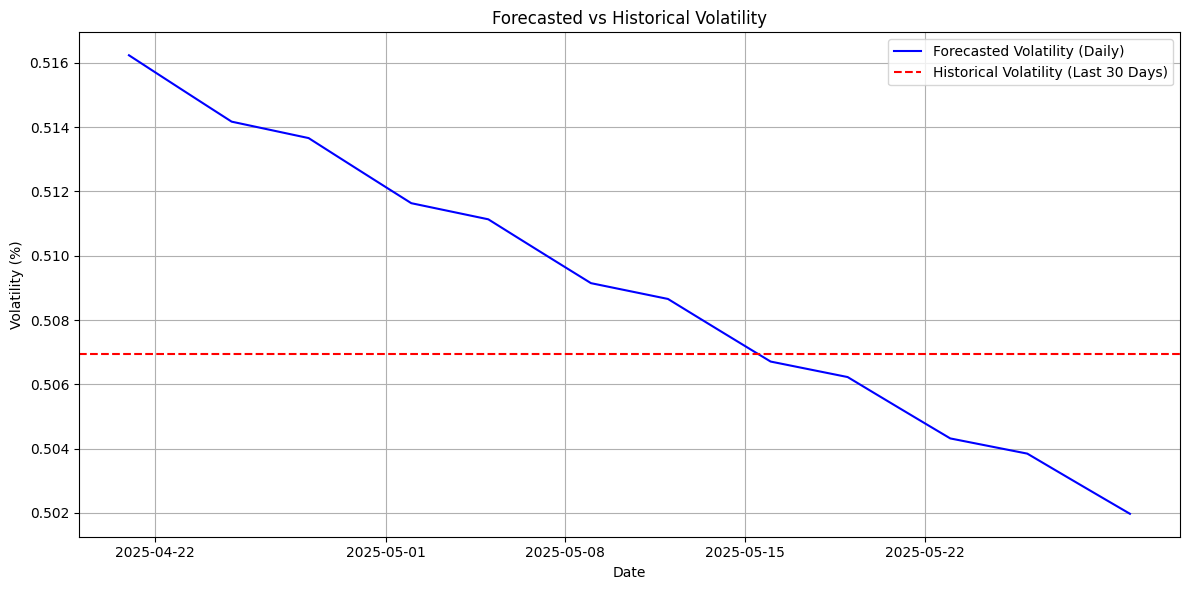

In [17]:

# 📈 Plot Forecasted Volatility vs Historical Volatility

import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 6))
plt.plot(vol_df.index, vol_df['Forecasted_Volatility'], label='Forecasted Volatility (Daily)', color='blue')
plt.axhline(hist_vol, color='red', linestyle='--', label='Historical Volatility (Last 30 Days)')
plt.title('Forecasted vs Historical Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### About the GARCH Model
The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is used to estimate volatility in financial time series data. It accounts for volatility clustering, where high-volatility periods tend to cluster together. GARCH models are instrumental in financial forecasting and risk analysis.


---

### ✅ Summary:
- **Forecasted Volatility on May 30, 2025** gives insight into expected market uncertainty ahead.
- **Historical Volatility** provides context using recent actual data.
- A visual comparison helps understand whether the market is expected to calm or become more volatile.



### Additional Points:
- The GARCH model was effective in capturing volatility clustering in EUR/SGD exchange rate data.
- Forecasts generated using the GARCH model can be instrumental for risk management and financial decision-making.
- The Ljung-Box test confirmed the adequacy of the GARCH model in handling autocorrelation in residuals.
- Further enhancements could involve incorporating exogenous variables or using GARCH variants like EGARCH or GJR-GARCH.